In [1]:
# Download Mask RCNN Repository
! git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.85 MiB | 12.20 MiB/s, done.
Resolving deltas: 100% (563/563), done.


In [2]:
# installing dependency for google collab
!pip uninstall -y tensorflow
!pip uninstall -y tensorflow-gpu
!pip install tensorflow-gpu==1.14.0
!pip install keras==2.1.3

Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 377.0MB 43kB/s 
     |████████████████████████████████| 3.2MB 43.9MB/s 
     |████████████████████████████████| 491kB 46.5MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
     |████████████████████████████████| 327kB 13.3MB/s 
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.3 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [3]:
import os
import sys
import json
from imgaug import augmenters as iaa
import numpy as np
import itertools
import math
import logging
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

In [4]:
# Root directory of the project
# When drive is mounted, prepend content 
ROOT_DIR = os.path.join('Mask_RCNN')
sys.path.append(ROOT_DIR)
# append mounted google drive to path for using mrcnn
GDRIVE_DATASET_PATH  = os.path.join('drive','My Drive','Colab Notebooks','mask_rcnn')
sys.path.append(GDRIVE_DATASET_PATH)

In [5]:
# loading modules after path is added
from loader import DamConfig, FarmDamDataset
import mrcnn.model as modellib

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [6]:
# Global variables after path is mounted
# path/gdrive path where the model is saved
MODEL_PERS_DIR = os.path.join(GDRIVE_DATASET_PATH, 'farm_dam', 'model')
# training part
DATASET_PATH = os.path.join(os.getcwd(), GDRIVE_DATASET_PATH,'farm_dam')
# saved model path
SAVED_MODEL_PATH = os.path.join(MODEL_PERS_DIR,'farm_dam20201005T0942','mask_rcnn_farm_dam_0040.h5')

In [7]:
# validation images dir
dataset_val = FarmDamDataset()
dataset_val.load_dam(DATASET_PATH, "val")
dataset_val.prepare()

In [8]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

In [9]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [36]:
# This code section is added for debugging, since needed to upload loader each time
from mrcnn.config import Config

class DamConfig(Config):
    """
    Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "farm_dam"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + FarmDam Class

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 16

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7


    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 1024

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 80% confidence
    DETECTION_MIN_CONFIDENCE = 0.7

    WEIGHT_DECAY = 0.001
    LEARNING_RATE = 0.0001
    VALIDATION_STEPS = 10
  
class InferenceConfig(DamConfig):
      # Set batch size to 1 since we'll be running inference on
      # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
      GPU_COUNT = 1
      IMAGES_PER_GPU = 1

In [37]:
inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE       

In [39]:
def load_transfered_learned_model(model_per_dir, model_saved_path, config):
  # Create model in training mode
  model = modellib.MaskRCNN(mode="inference", config=config, model_dir=model_per_dir)
  # Load weights trained on MS COCO, but skip layers that
  # are different due to the different number of classes
  print("Loading weights from ", model_saved_path)
  model.load_weights(model_saved_path, by_name=True)
  return model

# load transfered learned model to memory
model = load_transfered_learned_model(MODEL_PERS_DIR, SAVED_MODEL_PATH, inference_config)

Loading weights from  drive/My Drive/Colab Notebooks/mask_rcnn/farm_dam/model/farm_dam20201005T0942/mask_rcnn_farm_dam_0040.h5
Re-starting from epoch 40


image ID: farmdam.Img Captured 111.JPG (14) /content/drive/My Drive/Colab Notebooks/mask_rcnn/farm_dam/val/Img Captured 111.JPG
Original image shape:  [ 821 1598    3]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max: 1598.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
gt_class_id              shape: (9,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (9, 4)                min:  161.00000  max:  763.00000  int32
gt_mask                  shape: (1024, 1024, 9)       min:    0.00000  max:    1.00000  uint8
AP @0.50:	 0.778
AP @0.55:	 0.778
AP @0.60:	 0.778
AP @0.65:	 0.778
AP @0.70:	 0.778
AP @0.75:	 0.778
AP @0.80:	 0.556
AP @0.85:	 0.306
AP @0.90:	 0.1

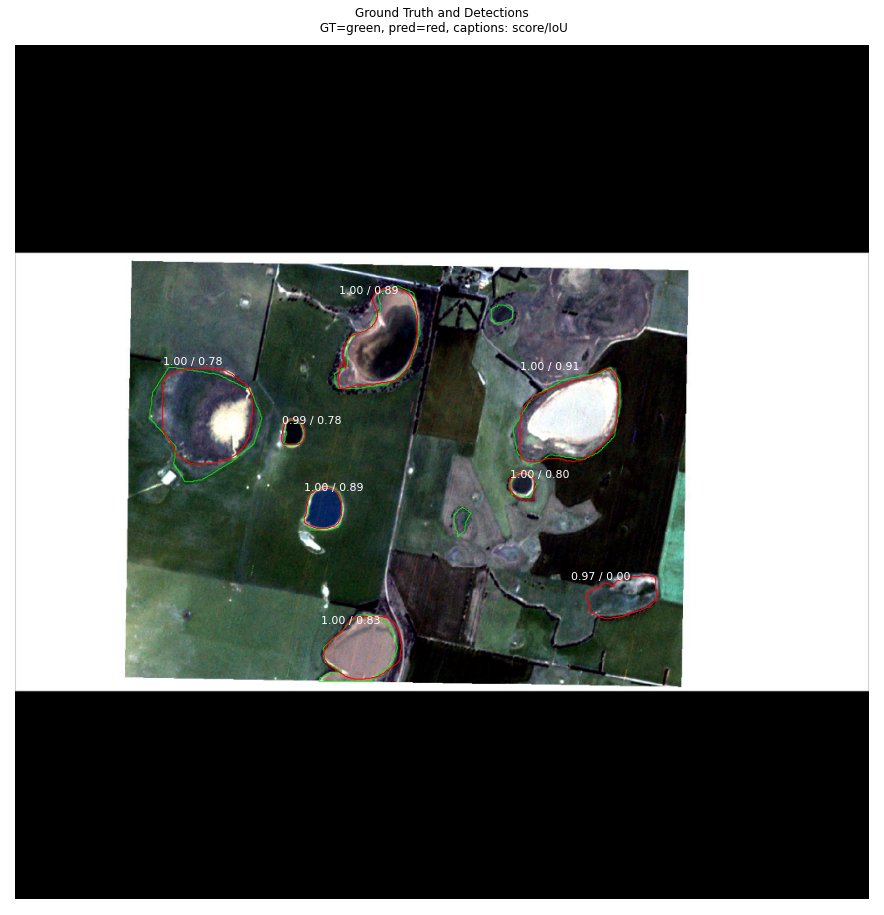

In [67]:
# Run detection
image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset_val.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.8)

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1597.00000  float64
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:  135.00000  max:  864.00000  int32
gt_mask                  shape: (1024, 1024, 10)      min:    0.00000  max:    1.00000  uint8


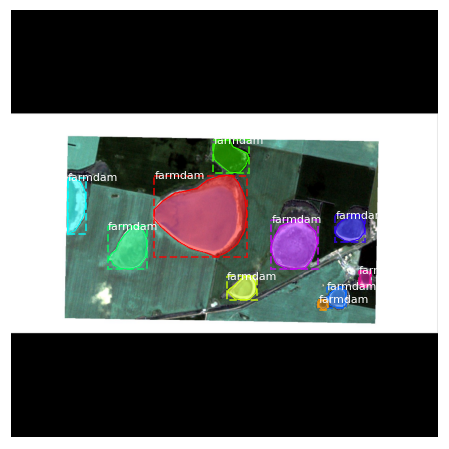

In [47]:
# original mask visualization

# visualize sample image
log("original_image", image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))